# Approximate Master Equations

**Âmes** is French for souls. **AMEs**, the acronym for approximate master equations, are almost as powerful and magical.

The biggest issue with master equations is that they scale directly with the number of states available to the system. Complex systems are generally made of large systems of $N$ interacting parts. Even in simple binary dynamics, this would imply $2^N$ possible states for the system. In order to use master equations to model real complex systems, we will need to break down these systems in subsystems and coarse-grain the systems of master equations. Of course, doing so means our approach won't be exact and won't fully describe the system, but it is still powerful. We call this approach **Approximate Master Equations**.

We illustrate AMEs with a few examples below.

## AMEs for networks

We will quickly cover two general approaches to AMEs on networks:

- Node-based AMEs which compress networks based on the state of nodes and of their neighbors, introduced in **_Adaptive networks: Coevolution of disease and topology_** {cite}`marceau2010adaptive`
- Group-based AMEs which compress networks based on the states of nodes within cliques or groups, introduced **_Propagation dynamics on networks featuring complex topologies_** {cite}`hebert2010propagation`. Some say that the approach is better described in **_Master equation analysis of mesoscopic localization in contagion dynamics on higher-order networks_** {cite}`st-onge2021master`.

The two approaches are summarized on the figure below using a simple network where nodes are either blue or red and groups either triangle or simple links. 

![ame_schematic](assets/png/ames.png)

The node-based approach breaks down a network based on the states available for nodes and the $k+1$ states available to their neighborhood of $k$ neighbors. For example, in binary dynamics, a node of degree 2 can have 3 possible neighborhoods: 2 red nodes, 2 blue nodes, or 1 of each. We can thus write master equations covering all possible states for star-motifs, with a different set of master equations for every degree class in the network. In our example above, the node-based approach is summarized in the top right corner of the cartoon, and would require 24 equations to fully describe. That's 14 for the hub of degree 6 (7 per state of the hub), 6 for the nodes of degree 2, and 4 for the leaves of degree 1.

The group-based approach breaks down a network based on well-defined groups like fully connected cliques and on the states of nodes they contain. For example, the network above contains cliques of size two (edges) and three (triangles). In binary dynamics, a clique of size $n$ can be in $n+1$ states. To couple them, the group-based approach also tracks nodes based on their state and the number of groups they belong to. The entire approach is summarized in the bottom corner of the cartoon. So, this simple example would require 7 group equations and 4 member equations to describe with group-based AMEs; 11 equations total.

## Logic of node-based AMEs

Say that we are interested in the SIS dynamics (or any other binary state model) on a network composed of $N$ nodes and $M$ edges. We then decompose the network into a set of $N$ node-based motifs, each composed of a central root node and its $k$ neighbors. A node of degree $k$ is therefore involved in one motif where it acts as a root and in $k$ motifs where it acts as a leaf. We describe the local dynamics of these motifs exactly, which involves tracking the recovery of infected nodes, the infection of leaves by the root, or vice versa. Moreover, the leaves can also be infected by their *other* neighbors, which we will assume to be random such that motifs are connected through a mean-field quantity. This is the *approximation* in approximate master equations. 

To track the exact state of any motif, these master equations require two degrees of freedom. One tracks the state of the root node, either susceptible denoted $S$ or infectious denoted $I$. The other requires the degree $k$ of the root node, i.e., the number of leaves, and then tracks how many neighbors $\ell$ are infectious. We then track the probability mass of this motif using an approximate master equation over the occupation numbers $S_{k,\ell}$ and $I_{k,\ell}$.

We have $S_{k,\ell}(t)$ and $I_{k,\ell}(t)$, the fractions of nodes that are respectively susceptible and infectious and that have total degree $k$ with $\ell$ infectious neighbours at time $t$. From there, the dynamics within the motif will follow standard master equations procedures with transitions related to the recovery of the root or neighbours and to the infection of the root or neighbours. The trickier part is to approximately capture the coupling between motifs. And for that, we define some important quantities.

The zero-th order moment of the $S_{k,\ell}$ and $I_{k,\ell}$ distributions gives us the fraction of susceptible and infectious nodes in the network at time $t$:

$$
S = \sum_{k,\ell} S_{k,\ell} \quad \textrm{and} \quad I = \sum_{k,\ell} I_{k,\ell} \; .
$$

The first order moments give us, for example, the expected number of susceptible/infectious neighbours of susceptible nodes, respectively $S_S$ and $S_I$ tagged by the state of the root node first:

$$
S_S = \sum_{k,\ell} (k-\ell)S_{k,\ell} \quad \textrm{and} \quad S_I = \sum_{k,\ell} \ell S_{k,\ell} \; .
$$

And the second order moments can give us, for example, the number of arcs (or paths of length two) in the networks that are rooted on susceptible nodes and connect a susceptible/infectious node to an infectious nodes:

$$
S_{SI} = \sum_{k,\ell} (k-\ell)\ell S_{k,\ell} \quad \textrm{and} \quad S_{II} = \sum_{k,\ell} \ell(\ell-1) S_{k,\ell} \; .
$$

With these quantities, we can derive the mean-field coupling between motifs. For example, a susceptible neighbour of a susceptible node will be in contact with an expected number of infectious neighbours equal to:

$$
\theta_1 = \frac{S_{SI}}{S_S}
$$

as that quantities is equal to the expected number of paths over three nodes that go "susceptible" to "susceptible" to "infectious", for every path that "susceptible" to "susceptible". Likewise, we can calculate the expected number of paths over three nodes that go "infectious" to "susceptible" to "infectious", for every path that "infectious" to "susceptible":

$$
\theta_2 = 1+\frac{S_{II}}{S_I} \; .
$$

## Implementation of node-based AMEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
plt.style.use(['ggplot'])

# We will use the odeint routine
from scipy.integrate import odeint

#Here, we will also use a global dictionary to keep track of states
#state_dict: keys are equation number and values are states (dictionary)
global d
d = {}

# Master Equations
def node_AME(x, t, beta, alpha):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * t is time (scalar)
        * beta is the transmission rate (scalar)
        * alpha is the recovery rate (scalar)
    """
    #prepare data structure
    dx = 0*x

    #calculate mean-field couplings
    Ss, Si, Ssi, Sii = 0.0, 0.0, 0.0, 0.0
    for state, eq_no in d.items():
        (root, k, l) = state
        if root==0: 
          Ss += (k-l)*x[eq_no]
          Si += l*x[eq_no]
          Ssi += (k-l)*l*x[eq_no]
          Sii += l*(l-1)*x[eq_no]
    if Ss>0.0:
      theta1 = Ssi/Ss
    else:
      theta1 = 0.0
    if Si>0.0:
      theta2 = 1+Sii/Si
    else:
      theta2 = 0.0

    #define equations
    for state, eq_no in d.items():
      (root, k, l) = state
      if root==0: #S_kl system
        dx[eq_no] = alpha*x[d[(1,k,l)]] - beta*l*x[eq_no] #root node dynamics
        dx[eq_no] -= alpha*l*x[eq_no] + beta*theta1*(k-l)*x[eq_no] #leaf output
        if(l<k): dx[eq_no] += alpha*(l+1)*x[d[(0,k,l+1)]] #leaf input
        if(l>0): dx[eq_no] += beta*theta1*(k-l+1)*x[d[(0,k,l-1)]] #leaf input
      elif root==1: #I_kl system
        dx[eq_no] = -alpha*x[eq_no] + beta*l*x[d[(0,k,l)]]  #root node dynamics
        dx[eq_no] -= alpha*l*x[eq_no] + beta*(1+theta2)*(k-l)*x[eq_no] #leaf output
        if(l<k): dx[eq_no] += alpha*(l+1)*x[d[(1,k,l+1)]] #leaf input
        if(l>0): dx[eq_no] += beta*(1+theta2)*(k-l+1)*x[d[(1,k,l-1)]] #leaf input

    return dx

# Time of observations
t_length = 20
t_steps = t_length+1
t_vec = np.linspace(0, t_length, t_steps)

# Parameters
beta = 0.5
alpha = 1.0
p = 0.5 #parameter for geometric degree distribution

# Initial conditions: All nodes are infectious
kmax = 20
x_0 = np.zeros((int(kmax*(kmax+1))))
eq = 0
for i in range(2): #loop over root state
  for k in range(kmax): #loop over degree distribution
    for l in range(k+1): #loop over neighbour states
      d[(i, k, l)] = eq
      if i==1 and l==k:
        x_0[eq] = p*(1-p)**k
      eq += 1
  
# Integration
G = lambda x, t: node_AME(x, t, beta, alpha)
x_path = odeint(G, x_0, t_vec)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


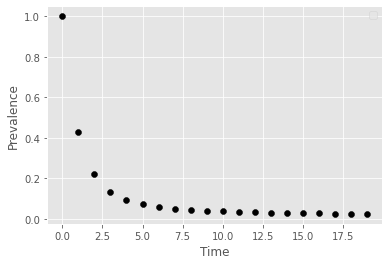

In [2]:
# Plot
for t in range(t_length):
  x = x_path[t]
  I = 0
  for (root, k, l), eq_no in d.items():
    if root==1: I+=x[eq_no] 
  plt.scatter(t,I, marker="o",color='black')
plt.ylabel('Prevalence')
plt.xlabel('Time')
plt.show()